# Contents

1. [The Problem](#The-Problem)
2. [Common Libraries](#Common-Libraries)
3. [Import Data](#Import-Data)
4. [Explore Data](#Explore-Data)
5. [Prepare Data](#Prepare-Data)
6. [Shortlist Models](#Shortlist-Models)
7. [Tune Models](#Tune-Models)
8. [Submission](#Submission)

# The Problem

For now, you can read about the problem on Kaggle. 

Based on that, this qualifies as a supervised multivariate classification problem in which we'll use batch learning from the supplied dataset.

## Performance evaluation 
As described in the Kaggle description, the performance will be evaluated using the Macro F1 Score. 

Todo:
* Describe the F1 score and evaluate if it's a good fit.
* Is the right measure given the business objectives?
* Minimumm performance required?
* List assumptions

# Common Libraries

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Set up Seaborn with default theme, scaling, and color palette
sns.set()

#Scikit-learn common imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

# Import Data

In [2]:
def import_train_test():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    
    return train, test

train, test = import_train_test()

# Explore Data

In [3]:
print(train.shape)
train.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
print(test.shape)
test.head()

(23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


Okay, first things we notice is that we have 9,557 rows in our training set and 23,856 in our test set. Each row represents an individual and the household they correspond it is indicated by their `idhogar` value. According to the business objective, we are only interested in classifying households, the `Target` should be the same for every individual in a household. Let's see how many households are in each set.

In [5]:
print(f"There are {len(train.idhogar.unique())} unique households in the training set.")
print(f"There are {len(test.idhogar.unique())} unique households in the test set.")

There are 2988 unique households in the training set.
There are 7352 unique households in the test set.


Almost 2.5 times the number of households in the test set. This means we should be very cautious to make sure that our model doesn't overfit the training set because if we do, we'll likely score pretty poorly on the test submission.

Let's take a look at the label distirbution both for individuals and household.

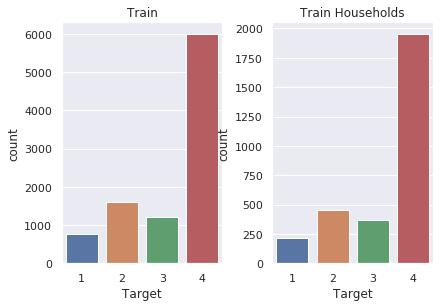

In [6]:
fig, axs = plt.subplots(1,2)
fig.tight_layout()

sns.countplot(x='Target', data=train, ax=axs[0])
axs[0].set_title('Train')

sns.countplot(x='Target', data=train.copy().groupby('idhogar').first(), ax=axs[1])
axs[1].set_title('Train Households')

plt.show()

Okay, looks like we're okay in terms of the distributions between the train set and the extracted households. We should take not that our classes are very imbalanced. If the test set follows the same distribution, we could use a naive model that simply predicts the `Target` to be 4 and we'll be right over 65% of the time. This certainly won't help IDB figure out how to focus their support, since most households would be classified as non-vulnerable and, therefore, not in need of additional support. Still, it's good to be aware of this as we evaluate our models.

It seems like a lot of the features in the dataset are boolean. To start exploring the data and distributions, let's take a look at all the numeric attributes that aren't boolean to see what their distributions are and see if we can identify anything interesting about the data we're working with.

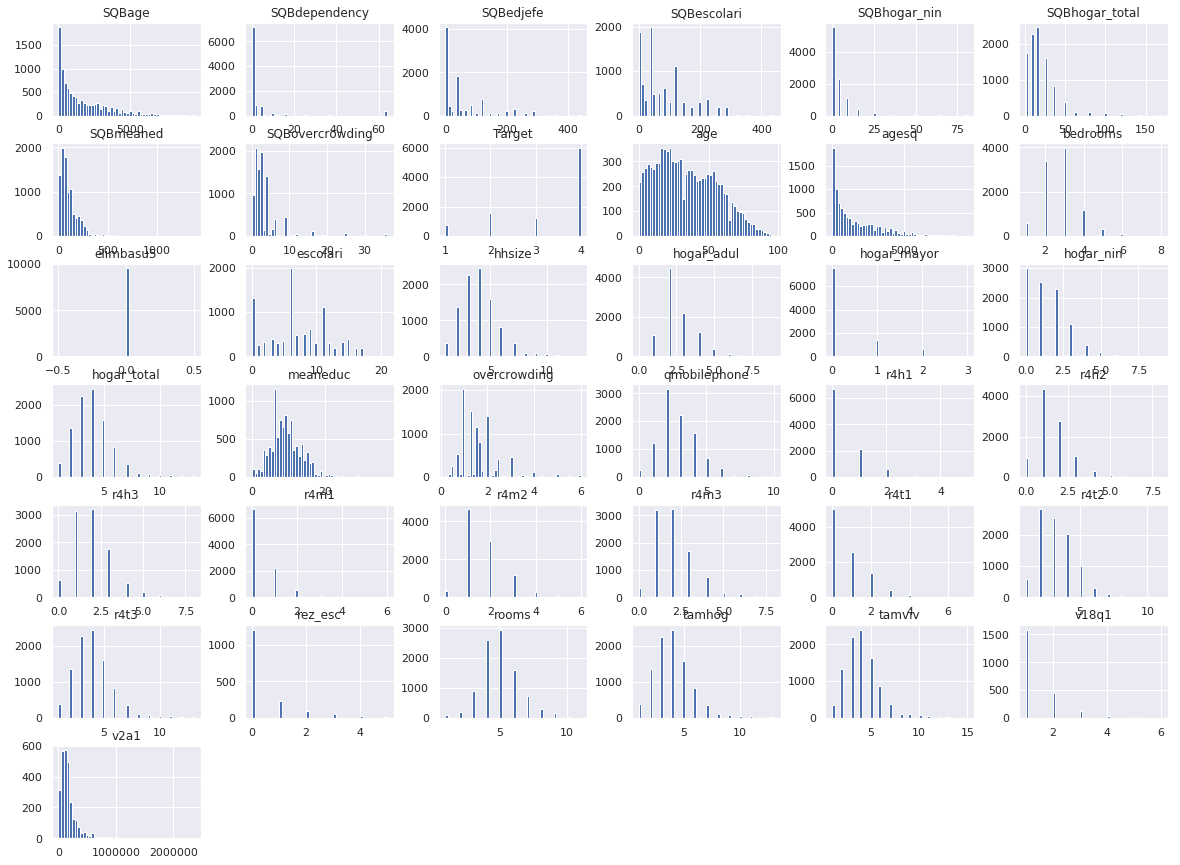

In [7]:
def is_boolean_column(data, column):
    return set(data[column].value_counts().keys()) == {0,1}
    
numeric_non_boolean_attributes = [column for column in train.columns if not is_boolean_column(train, column)]

train.hist(numeric_non_boolean_attributes, bins=50, figsize=(20,15))
plt.show()

From the above histograms, we can see a couple interesting things that we should be aware of and possibly address before training our models. Specifically:

* While a lot of the attributes resemble a normal distribution, many have long tails and some are skewed heavily 
* `elimbasu5`, which shouldn't be in here since it is a boolean field, but by being in here we can see that all of the values are 0. If that's the case, this doesn't tell us anything, so we shouldn't pass that to our model.
* There is a lot of variance in the values, so we'll need to scale these before training our model.

## Outlier Detection
Let's find any attribute that has values outside the IQR.


In [115]:
q1s = train[numeric_non_boolean_attributes].quantile(0.25)
q3s = train[numeric_non_boolean_attributes].quantile(0.75)

iqrs = pd.DataFrame([q1s, q3s], index=['q1', 'q3']).transpose().drop('Target')
iqrs['iqr'] = iqrs.q3 - iqrs.q1
iqrs['iqr_amplified'] = iqrs.iqr * 1.5
iqrs['outlier_min'] = iqrs.q1 - iqrs.iqr_amplified
iqrs['outlier_max'] = iqrs.q3 + iqrs.iqr_amplified

def min_outlier_count(iqr_row):
    return len(train[train[iqr_row.name] < iqrs.loc[[iqr_row.name]].outlier_min[0]])

def max_outlier_count(iqr_row):
    return len(train[train[iqr_row.name] > iqrs.loc[[iqr_row.name]].outlier_max[0]])

iqrs['min_outlier_count'] = iqrs.apply(min_outlier_count, axis=1)
iqrs['max_outlier_count'] = iqrs.apply(max_outlier_count, axis=1)
iqrs[(iqrs.min_outlier_count > 0) | (iqrs.max_outlier_count > 0)]

,q1,q3,iqr,iqr_amplified,outlier_min,outlier_max,min_outlier_count,max_outlier_count
v2a1,80000.000000,200000.000000,120000.000000,180000.000000,-100000.000000,380000.000000,0,186
rooms,4.000000,6.000000,2.000000,3.000000,1.000000,9.000000,0,50
v18q1,1.000000,2.000000,1.000000,1.500000,-0.500000,3.500000,0,56
r4h1,0.000000,1.000000,1.000000,1.500000,-1.500000,2.500000,0,91
r4h2,1.000000,2.000000,1.000000,1.500000,-0.500000,3.500000,0,401
r4h3,1.000000,3.000000,2.000000,3.000000,-2.000000,6.000000,0,34
r4m1,0.000000,1.000000,1.000000,1.500000,-1.500000,2.500000,0,136
r4m2,1.000000,2.000000,1.000000,1.500000,-0.500000,3.500000,0,379
r4m3,1.000000,3.000000,2.000000,3.000000,-2.000000,6.000000,0,48
r4t1,0.000000,1.000000,1.000000,1.500000,-1.500000,2.500000,0,599


In [105]:
train.loc[train.hogar_adul < 0.5, ['Id', 'idhogar', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'Target']]

,Id,idhogar,hogar_adul,hogar_mayor,hogar_nin,hogar_total,Target
1291,ID_bd8e11b0f,1b31fd159,0,0,1,1,4
1840,ID_46ff87316,a874b7ce7,0,0,2,2,4
1841,ID_69f50bf3e,a874b7ce7,0,0,2,2,4
2049,ID_db3168f9f,faaebf71a,0,0,2,2,4
2050,ID_2a7615902,faaebf71a,0,0,2,2,4


In [108]:
train.loc[train.rooms > iqrs.loc[['rooms']].outlier_max[0], ['Id', 'idhogar', 'rooms', 'Target']]

,Id,idhogar,rooms,Target
272,ID_f3f22bc48,bdd842cfd,10,4
273,ID_f630a9acf,bdd842cfd,10,4
274,ID_6eaba237a,bdd842cfd,10,4
275,ID_48cc48938,bdd842cfd,10,4
276,ID_397744c3b,bdd842cfd,10,4
277,ID_b7d8eb497,bdd842cfd,10,4
435,ID_ac207dfee,4476ccd4c,10,4
436,ID_28a31d303,4476ccd4c,10,4
437,ID_acc8558a5,4476ccd4c,10,4
438,ID_f488bed18,4476ccd4c,10,4


## Attribute Correlation
Let's also evaluate if there's any obvious correlation between any of the attributes and the target variable that we should be aware of at this point.

In [8]:
correlations = train.copy().corr()

correlations['Target'].where(correlations['Target'].abs() > 0.25).dropna().sort_values(ascending=False)

Target             1.000000
meaneduc           0.335203
cielorazo          0.304421
escolari           0.302305
SQBescolari        0.296577
eviv3              0.294222
epared3            0.292451
pisomoscer         0.280284
SQBmeaned          0.276620
v2a1               0.273559
paredblolad        0.261274
etecho3            0.257378
r4m1              -0.253163
SQBovercrowding   -0.258744
overcrowding      -0.289110
SQBhogar_nin      -0.311186
r4t1              -0.316745
hogar_nin         -0.328199
Name: Target, dtype: float64

We can see that there a few weakly correlated attributes with the target variabe, `Target`. That's good news, otherwise we'd have a tough time training a model worth anything. 

One other thing I notice here is that the squared eqivalent attributes, e.g. `SQBescolari` to `escolari` seem to have a lower correlation to the un-squared attribute. We might want to omit the squared variables.

`meaneduc`, average years of education for adults (18+), and `hogar_nin`, Number of children 0 to 19 in household, are the most correlated attributes, so we should pay extra attention to those two concepts.

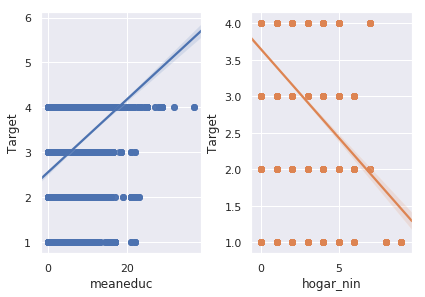

In [9]:
fig, axs = plt.subplots(1,2)
fig.tight_layout()

sns.regplot(x='meaneduc', y='Target', data=train, ax=axs[0])
sns.regplot(x='hogar_nin', y='Target', data=train, ax=axs[1])

plt.show()

# Data Cleaning

First, let's create some reference dictionaries we'll use for the features

In [10]:
id_features = ['Id', 'idhogar']

features_and_descriptions = [('v2a1', 'Monthly rent payment'),
                             ('hacdor', '=1 Overcrowding by bedrooms'),
                             ('rooms', 'number of all rooms in the house'),
                             ('hacapo', '=1 Overcrowding by rooms'),
                             ('v14a', '=1 has bathroom in the household'),
                             ('refrig', '=1 if the household has refrigerator'),
                             ('v18q', 'owns a tablet'),
                             ('v18q1', 'number of tablets household owns'),
                             ('r4h1', 'Males younger than 12 years of age'),
                             ('r4h2', 'Males 12 years of age and older'),
                             ('r4h3', 'Total males in the household'),
                             ('r4m1', 'Females younger than 12 years of age'),
                             ('r4m2', 'Females 12 years of age and older'),
                             ('r4m3', 'Total females in the household'),
                             ('r4t1', 'persons younger than 12 years of age'),
                             ('r4t2', 'persons 12 years of age and older'),
                             ('r4t3', 'Total persons in the household'),
                             ('tamhog', 'size of the household'),
                             ('tamviv', 'number of persons living in the household'),
                             ('escolari', 'years of schooling'),
                             ('rez_esc', 'Years behind in school'),
                             ('hhsize', 'household size'),
                             ('paredblolad', '=1 if predominant material on the outside wall is block or brick'),
                             ('paredzocalo', '"=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"'),
                             ('paredpreb', '=1 if predominant material on the outside wall is prefabricated or cement'),
                             ('pareddes', '=1 if predominant material on the outside wall is waste material'),
                             ('paredmad', '=1 if predominant material on the outside wall is wood'),
                             ('paredzinc', '=1 if predominant material on the outside wall is zink'),
                             ('paredfibras', '=1 if predominant material on the outside wall is natural fibers'),
                             ('paredother', '=1 if predominant material on the outside wall is other'),
                             ('pisomoscer', '"=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"'),
                             ('pisocemento', '=1 if predominant material on the floor is cement'),
                             ('pisoother', '=1 if predominant material on the floor is other'),
                             ('pisonatur', '=1 if predominant material on the floor is  natural material'),
                             ('pisonotiene', '=1 if no floor at the household'),
                             ('pisomadera', '=1 if predominant material on the floor is wood'),
                             ('techozinc', '=1 if predominant material on the roof is metal foil or zink'),
                             ('techoentrepiso', '"=1 if predominant material on the roof is fiber cement,  mezzanine "'),
                             ('techocane', '=1 if predominant material on the roof is natural fibers'),
                             ('techootro', '=1 if predominant material on the roof is other'),
                             ('cielorazo', '=1 if the house has ceiling'),
                             ('abastaguadentro', '=1 if water provision inside the dwelling'),
                             ('abastaguafuera', '=1 if water provision outside the dwelling'),
                             ('abastaguano', '=1 if no water provision'),
                             ('public', '"=1 electricity from CNFL,  ICE,  ESPH/JASEC"'),
                             ('planpri', '=1 electricity from private plant'),
                             ('noelec', '=1 no electricity in the dwelling'),
                             ('coopele', '=1 electricity from cooperative'),
                             ('sanitario1', '=1 no toilet in the dwelling'),
                             ('sanitario2', '=1 toilet connected to sewer or cesspool'),
                             ('sanitario3', '=1 toilet connected to  septic tank'),
                             ('sanitario5', '=1 toilet connected to black hole or letrine'),
                             ('sanitario6', '=1 toilet connected to other system'),
                             ('energcocinar1', '=1 no main source of energy used for cooking (no kitchen)'),
                             ('energcocinar2', '=1 main source of energy used for cooking electricity'),
                             ('energcocinar3', '=1 main source of energy used for cooking gas'),
                             ('energcocinar4', '=1 main source of energy used for cooking wood charcoal'),
                             ('elimbasu1', '=1 if rubbish disposal mainly by tanker truck'),
                             ('elimbasu2', '=1 if rubbish disposal mainly by botan hollow or buried'),
                             ('elimbasu3', '=1 if rubbish disposal mainly by burning'),
                             ('elimbasu4', '=1 if rubbish disposal mainly by throwing in an unoccupied space'),
                             ('elimbasu5', '"=1 if rubbish disposal mainly by throwing in river,  creek or sea"'),
                             ('elimbasu6', '=1 if rubbish disposal mainly other'),
                             ('epared1', '=1 if walls are bad'),
                             ('epared2', '=1 if walls are regular'),
                             ('epared3', '=1 if walls are good'),
                             ('etecho1', '=1 if roof are bad'),
                             ('etecho2', '=1 if roof are regular'),
                             ('etecho3', '=1 if roof are good'),
                             ('eviv1', '=1 if floor are bad'),
                             ('eviv2', '=1 if floor are regular'),
                             ('eviv3', '=1 if floor are good'),
                             ('dis', '=1 if disable person'),
                             ('male', '=1 if male'),
                             ('female', '=1 if female'),
                             ('estadocivil1', '=1 if less than 10 years old'),
                             ('estadocivil2', '=1 if free or coupled uunion'),
                             ('estadocivil3', '=1 if married'),
                             ('estadocivil4', '=1 if divorced'),
                             ('estadocivil5', '=1 if separated'),
                             ('estadocivil6', '=1 if widow/er'),
                             ('estadocivil7', '=1 if single'),
                             ('parentesco1', '=1 if household head'),
                             ('parentesco2', '=1 if spouse/partner'),
                             ('parentesco3', '=1 if son/doughter'),
                             ('parentesco4', '=1 if stepson/doughter'),
                             ('parentesco5', '=1 if son/doughter in law'),
                             ('parentesco6', '=1 if grandson/doughter'),
                             ('parentesco7', '=1 if mother/father'),
                             ('parentesco8', '=1 if father/mother in law'),
                             ('parentesco9', '=1 if brother/sister'),
                             ('parentesco10', '=1 if brother/sister in law'),
                             ('parentesco11', '=1 if other family member'),
                             ('parentesco12', '=1 if other non family member'),
                             ('idhogar', 'Household level identifier'),
                             ('hogar_nin', 'Number of children 0 to 19 in household'),
                             ('hogar_adul', 'Number of adults in household'),
                             ('hogar_mayor', '# of individuals 65+ in the household'),
                             ('hogar_total', '# of total individuals in the household'),
                             ('dependency', 'Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)'),
                             ('edjefe', 'years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('edjefa', 'years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('meaneduc', 'average years of education for adults (18+)'),
                             ('instlevel1', '=1 no level of education'),
                             ('instlevel2', '=1 incomplete primary'),
                             ('instlevel3', '=1 complete primary'),
                             ('instlevel4', '=1 incomplete academic secondary level'),
                             ('instlevel5', '=1 complete academic secondary level'),
                             ('instlevel6', '=1 incomplete technical secondary level'),
                             ('instlevel7', '=1 complete technical secondary level'),
                             ('instlevel8', '=1 undergraduate and higher education'),
                             ('instlevel9', '=1 postgraduate higher education'),
                             ('bedrooms', 'number of bedrooms'),
                             ('overcrowding', '# persons per room'),
                             ('tipovivi1', '=1 own and fully paid house'),
                             ('tipovivi2', '"=1 own,  paying in installments"'),
                             ('tipovivi3', '=1 rented'),
                             ('tipovivi4', '=1 precarious'),
                             ('tipovivi5', '"=1 other(assigned,  borrowed)"'),
                             ('computer', '=1 if the household has notebook or desktop computer'),
                             ('television', '=1 if the household has TV'),
                             ('mobilephone', '=1 if mobile phone'),
                             ('qmobilephone', '# of mobile phones'),
                             ('lugar1', '=1 region Central'),
                             ('lugar2', '=1 region Chorotega'),
                             ('lugar3', '=1 region PacÃƒÂ­fico central'),
                             ('lugar4', '=1 region Brunca'),
                             ('lugar5', '=1 region Huetar AtlÃƒÂ¡ntica'),
                             ('lugar6', '=1 region Huetar Norte'),
                             ('area1', '=1 zona urbana'),
                             ('area2', '=2 zona rural'),
                             ('age', 'Age in years'),
                             ('SQBescolari', 'escolari squared'),
                             ('SQBage', 'age squared'),
                             ('SQBhogar_total', 'hogar_total squared'),
                             ('SQBedjefe', 'edjefe squared'),
                             ('SQBhogar_nin', 'hogar_nin squared'),
                             ('SQBovercrowding', 'overcrowding squared'),
                             ('SQBdependency', 'dependency squared'),
                             ('SQBmeaned', 'square of the mean years of education of adults (>=18) in the household'),
                             ('agesq', 'Age squared')]

household_features_and_descriptions = [('v2a1', 'Monthly rent payment'),
                             ('hacdor', '=1 Overcrowding by bedrooms'),
                             ('rooms', 'number of all rooms in the house'),
                             ('hacapo', '=1 Overcrowding by rooms'),
                             ('v14a', '=1 has bathroom in the household'),
                             ('refrig', '=1 if the household has refrigerator'),
                             ('v18q1', 'number of tablets household owns'),
                             ('r4h1', 'Males younger than 12 years of age'),
                             ('r4h2', 'Males 12 years of age and older'),
                             ('r4h3', 'Total males in the household'),
                             ('r4m1', 'Females younger than 12 years of age'),
                             ('r4m2', 'Females 12 years of age and older'),
                             ('r4m3', 'Total females in the household'),
                             ('r4t1', 'persons younger than 12 years of age'),
                             ('r4t2', 'persons 12 years of age and older'),
                             ('r4t3', 'Total persons in the household'),
                             ('tamhog', 'size of the household'),
                             ('tamviv', 'number of persons living in the household'),
                             ('hhsize', 'household size'),
                             ('paredblolad', '=1 if predominant material on the outside wall is block or brick'),
                             ('paredzocalo', '"=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"'),
                             ('paredpreb', '=1 if predominant material on the outside wall is prefabricated or cement'),
                             ('pareddes', '=1 if predominant material on the outside wall is waste material'),
                             ('paredmad', '=1 if predominant material on the outside wall is wood'),
                             ('paredzinc', '=1 if predominant material on the outside wall is zink'),
                             ('paredfibras', '=1 if predominant material on the outside wall is natural fibers'),
                             ('paredother', '=1 if predominant material on the outside wall is other'),
                             ('pisomoscer', '"=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"'),
                             ('pisocemento', '=1 if predominant material on the floor is cement'),
                             ('pisoother', '=1 if predominant material on the floor is other'),
                             ('pisonatur', '=1 if predominant material on the floor is  natural material'),
                             ('pisonotiene', '=1 if no floor at the household'),
                             ('pisomadera', '=1 if predominant material on the floor is wood'),
                             ('techozinc', '=1 if predominant material on the roof is metal foil or zink'),
                             ('techoentrepiso', '"=1 if predominant material on the roof is fiber cement,  mezzanine "'),
                             ('techocane', '=1 if predominant material on the roof is natural fibers'),
                             ('techootro', '=1 if predominant material on the roof is other'),
                             ('cielorazo', '=1 if the house has ceiling'),
                             ('abastaguadentro', '=1 if water provision inside the dwelling'),
                             ('abastaguafuera', '=1 if water provision outside the dwelling'),
                             ('abastaguano', '=1 if no water provision'),
                             ('public', '"=1 electricity from CNFL,  ICE,  ESPH/JASEC"'),
                             ('planpri', '=1 electricity from private plant'),
                             ('noelec', '=1 no electricity in the dwelling'),
                             ('coopele', '=1 electricity from cooperative'),
                             ('sanitario1', '=1 no toilet in the dwelling'),
                             ('sanitario2', '=1 toilet connected to sewer or cesspool'),
                             ('sanitario3', '=1 toilet connected to  septic tank'),
                             ('sanitario5', '=1 toilet connected to black hole or letrine'),
                             ('sanitario6', '=1 toilet connected to other system'),
                             ('energcocinar1', '=1 no main source of energy used for cooking (no kitchen)'),
                             ('energcocinar2', '=1 main source of energy used for cooking electricity'),
                             ('energcocinar3', '=1 main source of energy used for cooking gas'),
                             ('energcocinar4', '=1 main source of energy used for cooking wood charcoal'),
                             ('elimbasu1', '=1 if rubbish disposal mainly by tanker truck'),
                             ('elimbasu2', '=1 if rubbish disposal mainly by botan hollow or buried'),
                             ('elimbasu3', '=1 if rubbish disposal mainly by burning'),
                             ('elimbasu4', '=1 if rubbish disposal mainly by throwing in an unoccupied space'),
                             ('elimbasu5', '"=1 if rubbish disposal mainly by throwing in river,  creek or sea"'),
                             ('elimbasu6', '=1 if rubbish disposal mainly other'),
                             ('epared1', '=1 if walls are bad'),
                             ('epared2', '=1 if walls are regular'),
                             ('epared3', '=1 if walls are good'),
                             ('etecho1', '=1 if roof are bad'),
                             ('etecho2', '=1 if roof are regular'),
                             ('etecho3', '=1 if roof are good'),
                             ('eviv1', '=1 if floor are bad'),
                             ('eviv2', '=1 if floor are regular'),
                             ('eviv3', '=1 if floor are good'),
                             ('hogar_nin', 'Number of children 0 to 19 in household'),
                             ('hogar_adul', 'Number of adults in household'),
                             ('hogar_mayor', '# of individuals 65+ in the household'),
                             ('hogar_total', '# of total individuals in the household'),
                             ('dependency', 'Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)'),
                             ('edjefe', 'years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('edjefa', 'years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('meaneduc', 'average years of education for adults (18+)'),
                             ('bedrooms', 'number of bedrooms'),
                             ('overcrowding', '# persons per room'),
                             ('tipovivi1', '=1 own and fully paid house'),
                             ('tipovivi2', '"=1 own,  paying in installments"'),
                             ('tipovivi3', '=1 rented'),
                             ('tipovivi4', '=1 precarious'),
                             ('tipovivi5', '"=1 other(assigned,  borrowed)"'),
                             ('computer', '=1 if the household has notebook or desktop computer'),
                             ('television', '=1 if the household has TV'),
                             ('mobilephone', '=1 if mobile phone'),
                             ('qmobilephone', '# of mobile phones'),
                             ('lugar1', '=1 region Central'),
                             ('lugar2', '=1 region Chorotega'),
                             ('lugar3', '=1 region PacÃƒÂ­fico central'),
                             ('lugar4', '=1 region Brunca'),
                             ('lugar5', '=1 region Huetar AtlÃƒÂ¡ntica'),
                             ('lugar6', '=1 region Huetar Norte'),
                             ('area1', '=1 zona urbana'),
                             ('area2', '=2 zona rural')]

household_features = [feature for feature, description in household_features_and_descriptions]

individual_features_and_descriptions = [('v18q', 'owns a tablet'),
                             ('escolari', 'years of schooling'),
                             ('rez_esc', 'Years behind in school'),
                             ('dis', '=1 if disable person'),
                             ('male', '=1 if male'),
                             ('female', '=1 if female'),
                             ('estadocivil1', '=1 if less than 10 years old'),
                             ('estadocivil2', '=1 if free or coupled uunion'),
                             ('estadocivil3', '=1 if married'),
                             ('estadocivil4', '=1 if divorced'),
                             ('estadocivil5', '=1 if separated'),
                             ('estadocivil6', '=1 if widow/er'),
                             ('estadocivil7', '=1 if single'),
                             ('parentesco1', '=1 if household head'),
                             ('parentesco2', '=1 if spouse/partner'),
                             ('parentesco3', '=1 if son/doughter'),
                             ('parentesco4', '=1 if stepson/doughter'),
                             ('parentesco5', '=1 if son/doughter in law'),
                             ('parentesco6', '=1 if grandson/doughter'),
                             ('parentesco7', '=1 if mother/father'),
                             ('parentesco8', '=1 if father/mother in law'),
                             ('parentesco9', '=1 if brother/sister'),
                             ('parentesco10', '=1 if brother/sister in law'),
                             ('parentesco11', '=1 if other family member'),
                             ('parentesco12', '=1 if other non family member'),
                             ('instlevel1', '=1 no level of education'),
                             ('instlevel2', '=1 incomplete primary'),
                             ('instlevel3', '=1 complete primary'),
                             ('instlevel4', '=1 incomplete academic secondary level'),
                             ('instlevel5', '=1 complete academic secondary level'),
                             ('instlevel6', '=1 incomplete technical secondary level'),
                             ('instlevel7', '=1 complete technical secondary level'),
                             ('instlevel8', '=1 undergraduate and higher education'),
                             ('instlevel9', '=1 postgraduate higher education'),
                             ('age', 'Age in years')]

individual_features = [feature for feature, description in individual_features_and_descriptions]

squared_features_and_descriptions = [('SQBescolari', 'escolari squared'),
                             ('SQBage', 'age squared'),
                             ('SQBhogar_total', 'hogar_total squared'),
                             ('SQBedjefe', 'edjefe squared'),
                             ('SQBhogar_nin', 'hogar_nin squared'),
                             ('SQBovercrowding', 'overcrowding squared'),
                             ('SQBdependency', 'dependency squared'),
                             ('SQBmeaned', 'square of the mean years of education of adults (>=18) in the household'),
                             ('agesq', 'Age squared')]

squared_features = [feature for feature, description in squared_features_and_descriptions]

squared_household_features_and_descriptions = [('SQBhogar_total', 'hogar_total squared'),
                             ('SQBedjefe', 'edjefe squared'),
                             ('SQBhogar_nin', 'hogar_nin squared'),
                             ('SQBovercrowding', 'overcrowding squared'),
                             ('SQBdependency', 'dependency squared'),
                             ('SQBmeaned', 'square of the mean years of education of adults (>=18) in the household')]

squared_household_features = [feature for feature, description in squared_household_features_and_descriptions]

squared_individual_features_and_descriptions = [('SQBescolari', 'escolari squared'),
                             ('SQBage', 'age squared'),
                             ('agesq', 'Age squared')]

squared_individual_features = [feature for feature, description in squared_individual_features_and_descriptions]

In [11]:
# Verify that seemingly duplicate attributes, SQBage and agesq, 
# are in fact duplicates and contain duplicate values in both train and test sets.

for df, name in [(train, 'train'), (test, 'test')]:
    assert df.agesq.equals(df.SQBage), f"agesq is not equivalent with SQBage in the {name} set"
    
# Remove duplicate column agesq from feature lists
lists_with_agesq = [features_and_descriptions, squared_features_and_descriptions, squared_individual_features_and_descriptions]
for feature_list in lists_with_agesq:
    try:
        feature_list.remove(('agesq', 'Age squared'))
    except:
        continue

# Verify we deleted them all
for feature_list in lists_with_agesq:
    assert 'agesq' not in {x for x, y in feature_list}, 'Duplicated column agesq is still in feature list.'

## Attributes with NaNs

In [12]:
def print_nan_counts(df):
    nan_counts = df.isna().sum()
    print(nan_counts[nan_counts > 0].sort_values(ascending = False))
    
print_nan_counts(train)

rez_esc      7928
v18q1        7342
v2a1         6860
SQBmeaned       5
meaneduc        5
dtype: int64


Good news is that for most features, there aren't a lot of missing values. Let's figure out how best to handle each of these.

### rez_esc

First, `rez_esc`. The description of this field is "Years behind in school".  Let's take a look to see if we can figure out why there are so many empty values here. My intuition is that it has something to do with whether the individual is in school or not. For example, a two year old can't really be "behind in school". Nor can a graduate. We'll also check to see if there's been any discussion for how this field was created by IDB.

In [13]:
print('Stats for potentially related characteristics for individuals where rez_esc isna.')
print(train[train.rez_esc.isna()][['age', 'escolari', 'meaneduc']].describe())

print('')
print('Stats for potentially related characteristics for individuals where rez_esc is not null.')
print(train[train.rez_esc.notna()][['age', 'escolari', 'meaneduc']].describe())

Stats for potentially related characteristics for individuals where rez_esc isna.
               age     escolari     meaneduc
count  7928.000000  7928.000000  7923.000000
mean     38.833249     7.647704     9.287157
std      20.989486     4.903780     4.175805
min       0.000000     0.000000     0.000000
25%      24.000000     5.000000     6.000000
50%      38.000000     7.000000     9.000000
75%      54.000000    11.000000    11.750000
max      97.000000    21.000000    37.000000

Stats for potentially related characteristics for individuals where rez_esc is not null.
               age     escolari     meaneduc
count  1629.000000  1629.000000  1629.000000
mean     12.258441     5.022713     8.960934
std       3.218325     2.926428     4.118580
min       7.000000     0.000000     0.000000
25%       9.000000     2.000000     6.000000
50%      12.000000     5.000000     8.500000
75%      15.000000     7.000000    11.000000
max      17.000000    11.000000    29.000000


The thing that jumps out from this analysis is that range for the age of individuals where `rez_esc` is not na is between 7 and 17. The other variables don't show an obvious difference. Indeed, IDB clarifies in a discussion about this variable: 

> This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. it is capped at 5.

As a first step, then, let's create a custom transformer that fills in 0 for anyone who is younger than 7 or older than 19.

In [14]:
class ZerofillRezEscOutOfBounds(BaseEstimator, TransformerMixin):
    """Zerofill rez_esc for any row where age is < 7 or age is > 19."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[X.rez_esc.isna() & ((X.age < 7) | (X.age > 19)), 'rez_esc'] = 0
        return X
        
    
zerofiller = ZerofillRezEscOutOfBounds()
train_zerofilled = zerofiller.transform(train.copy())

assert not train_zerofilled[(train_zerofilled.age < 7) | (train_zerofilled.age > 19)].rez_esc.isna().any(), 'There are individuals younger than 7 or older than 19 with a na value for rez_esc.'

print(f"There are {train_zerofilled.rez_esc.isna().sum()} individuals with a na value for rez_esc.")
print(f"There are {train_zerofilled[(train_zerofilled.age < 7) | (train_zerofilled.age > 19)].rez_esc.isna().sum()} individuals younger than 7 or older than 19 with a na value for rez_esc.")

There are 350 individuals with a na value for rez_esc.
There are 0 individuals younger than 7 or older than 19 with a na value for rez_esc.


For the remaining 350 individuals between 7 and 19, we'll begin by simply imputing their values as part of our data preprocessing pipeline step. If needed, we might look further into this and see if can make a more meanginful inference from other data. For now, though, we'll spend the time on getting a working model and just use a basic imputer.

**TODO**: I see in the IDB response that this should be capped at 5. We should check to see that everyone is capped correctly or evaluate whether this matters.

### v18q1

Next, let's look at **v18q1**. The description for this field is "number of tablets household owns". There's also a field `v18q`, which represents if the individual "owns a tablet".  Theoretically, `v18q1` would be a derivative field summing the `v18q` for the individuals in the household. It's possible a blank `v18q1` could  represent households without a tablet. Let's see if we can confirm these before plowing forward.

In [15]:
train.loc[train.v18q1 > 1, ['Id', 'idhogar', 'parentesco1', 'v18q', 'v18q1']].head(20)

,Id,idhogar,parentesco1,v18q,v18q1
61,ID_1db0ed392,65d20b573,1,1,2.0
62,ID_c70e4a951,65d20b573,0,1,2.0
63,ID_f1a8c2996,65d20b573,0,1,2.0
74,ID_4f75bf2e4,b2ceb3e5c,1,1,3.0
75,ID_dd93e20ec,b2ceb3e5c,0,1,3.0
76,ID_c8f69febe,b2ceb3e5c,0,1,3.0
117,ID_d189a7af6,ac94e73e6,0,1,2.0
118,ID_530183555,ac94e73e6,0,1,2.0
119,ID_2a67a7630,ac94e73e6,1,1,2.0
120,ID_60eaa56fd,ac94e73e6,0,1,2.0


Wrong! We can immediately see that the hypothesis that v18q1, the "number of tablets household owns" is *not* the sum of `v18q` for each individual in the household. Household 28ec0c747 lists 2 for `v18q1`, but a 1 for each of the 6 individual's `v18q`.

I'm now realizing that `v18q` is probably a boolean field indicating whether the household for that individual owns a tablet, similar to many of the other fields in the dataset. We can check.

In [16]:
train.v18q.value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

Bingo! All of the values in the `v18q` column are 0s or 1s. ***And...*** that 7342 count rings a bell. In fact, it's the count of the number of NaN values in the `v18q1` column. It's now pretty reasonable that any field that has a 0 in `v18q` is part of a houseold that doesn't own a tablet and, therefore, the count of tablets in the house, `v18q1` should be set to 0. First, let's make sure this isn't a fluke and that there are households with more than 1 tablet. 

In [17]:
print(train.v18q1.value_counts())
print(len(train.loc[(train.v18q == 0 & train.v18q1.isna())]))

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64
7342


Yep, I feel comfortable now creating a transformer to set those 0s. And, moreover, we might want to consider excluding `v18q` from the final features used in the models, since it's redundant with `v18q1`—0 for `v18q1` is equivalent with 0 `v18q` and anything else is equivalent to 1 `v18q`

In [18]:
class ZerofillV18q1ForFalseV18Q(BaseEstimator, TransformerMixin):
    """Zerofill v18q1 for any row where v18q is 0."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[X.v18q == 0, 'v18q1'] = 0
        return X
        
    
zerofiller = ZerofillV18q1ForFalseV18Q()
train_zerofilled = zerofiller.transform(train.copy())

assert not train_zerofilled.v18q1.isna().any(), 'There are individuals with na value for v18q1.'

### v21a1

Next up, let's look at the other attribute that had a lot of NaN values, `v2a1`, described as "Monthly rent payment". Why would someone not have a monthly rent payment? I can only think of a few valid reasons, they own a house outright, live with someone else rent-free, or are homeless. If we can't figure out how to fill in some of these values, we might have to ignore this field. That would be a shame, though, since there's probably a decent correlation with a household's poverty level and their rent (or whether they own their home). 

Again, the representitive from IDB offers some help in the [Kaggle discussions](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403#360694):

> In the example of v2a1 you should first filter by tipoviv3. Most households that don't have information will be households that do not rent or are not paying loans (tipoviv2). If a household is tipoviv3 and does not have information then you need to make a choice about the treatment of the variable either assume 0, impute a value or not use the variable. Basically in those cases we don't know the value.

Let's see what we can find out following that path.

In [19]:
for v in ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']:
    print(f"Value counts for {v} for individuals with missing v2a1:")
    print(train.loc[train.v2a1.isna(), v].value_counts())
    print('')

Value counts for tipovivi1 for individuals with missing v2a1:
1    5911
0     949
Name: tipovivi1, dtype: int64

Value counts for tipovivi2 for individuals with missing v2a1:
0    6860
Name: tipovivi2, dtype: int64

Value counts for tipovivi3 for individuals with missing v2a1:
0    6860
Name: tipovivi3, dtype: int64

Value counts for tipovivi4 for individuals with missing v2a1:
0    6697
1     163
Name: tipovivi4, dtype: int64

Value counts for tipovivi5 for individuals with missing v2a1:
0    6074
1     786
Name: tipovivi5, dtype: int64



We can see that most of the individuals who have a missing `v2a1` have a 1 for `tipovivi1`. Looking at the data definitions, this indicates individuals who "own and fully paid house". This corresponds to one of the hypotheses we had for why `v2a1` could be legitimately be blank. For these, we should fill with 0s.

What about the others with a missing `v2a1`? A few have a 1 for `tipovivi4` and the rest have a 1 for `tipovivi5`. These represent "precarious" and "other(assigned,  borrowed)", respectively. I'm not sure exactly what precarious refers to, but `tipovivi5`, homes that are assigned or borrowed probably can also be assigned a 0 value for `v2a1`. Since `tipovivi4` represents such a small percentage of this set, we could choose to impute those values or set them to 0 as well. As a first round, we're going to leave them as blank and impute them as part of our preprocessing pipeline, but should flag this as something we might want to revisit as we try to squeeze more performance from our models. We should probably do some research to find out if that is a common designation for housing. 

In [20]:
class ZerofillV2a1(BaseEstimator, TransformerMixin):
    """Zerofill v2a1 if tipovivi1 or tipovivi5 is 1."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[(X.v2a1.isna()) & ((X.tipovivi1 == 1) | (X.tipovivi5 == 1)), 'v2a1'] = 0
        return X
        
    
zerofiller = ZerofillV2a1()
train_zerofilled = zerofiller.transform(train.copy())

# Assert that everyone that isn't a tipovivi4 doesn't have a NaN value for v2a1
assert not train_zerofilled[train_zerofilled.tipovivi4 == 0].v2a1.isna().any(), 'There are individuals with na value for v2a1.'

Let's verify we've handled all the missing values we can.

In [21]:
nan_pipeline = make_pipeline(ZerofillRezEscOutOfBounds(), ZerofillV18q1ForFalseV18Q(), ZerofillV2a1())
train_nan = nan_pipeline.fit_transform(train.copy())

print_nan_counts(train_nan)

rez_esc      350
v2a1         163
SQBmeaned      5
meaneduc       5
dtype: int64


We've addressed all of the columns with a lot of missing values. We will address the remaining missing values by imputing them as part of our preprocessing pipeline. And the other two attributes are so small that we can either impute them as well or drop those rows. For later tuning, we may want to look at them further to see if we can make some smart decisions about what they should be. For now, I think we've successfully built some transformer to handle NaN values. Next up, let's handle text and categorical attributes.

## Text & Categorical Attributes

The way we typically handle text columns is eather one-hot encoding them or transforming them into an obvious numeric value, usually if the values are ordinal in nature. Let's see what we've got here.

In [22]:
train.select_dtypes(include='object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Aside from the IDs of the individual and household, there are really three columns, each that look to have a mix between numbers and yes, nos. According the data descriptions:

> dependency, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

> edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

> edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

It seems like for `edjefe` and `edjefa` they added "no" for anyone who had 0 years of education and "yes" for anyone with 1. We can easily transform those back to numeric columns. I am a little suspicious of why they would do the latter and would want to validate with the stakeholders that they didn't transform anyone with more than 1 years of education into a "yes". For now, we'll respect the data definition.

Dependency is a rate, though and doesn't list this rule. Luckily, I found in the discussion that this is a general rule and can be applied to the `dependency` field as well:

> yes it is a general rule we applied to the database. In these three cases (edjefe, edjefa, dependency), when converting formats the variables were not delabeled for some reason. In the database yes is always 1 and no is always 0.

In [23]:
class TransformYesNoToNumeric(BaseEstimator, TransformerMixin):
    """Transform edjefe, edjefa, and dependencey yes/no values to numeric values.
    yes=1 and no=0."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        replacements = {'yes': 1, 'no': 0}
        columns = [('edjefe', 'uint8'), 
                   ('edjefa', 'uint8'), 
                   ('dependency', 'float16')]
    
        for column, converted_type in columns:    
            if X[column].dtype == 'object':
                X[column] = X[column].replace(replacements).astype(converted_type)
        
        return X

yes_no_transformer = TransformYesNoToNumeric()
train_yes_no_transformed = yes_no_transformer.transform(train.copy())

# Assert that all columns aside from Id and idhogar are numeric
assert train_yes_no_transformed.select_dtypes(include='object').columns.values.tolist() == ['Id', 'idhogar'], 'There are columns aside from Id and idhogar that are type object.'

## Aggregating Individual Features to Household Features

Since the primary business objective is concerned with households, we're going to be training our model just on households. It would be a shame to lose all of the information embedded in all of the individual attributes. To address this, let's add some features that aggregate the individual attributes to the household level by applying a few different statistics

In [49]:
class AggregateIndividualFeatures(BaseEstimator, TransformerMixin):
    """Aggregate individual features per household by grouping them by idhogar and
    applying sum, min, max, std.
    
    New features will be added as {feature name}-{aggregation type}, e.g. age-std
    """
    def __init__(self):
        self.excluded_individual_features = ['v18q', 'male', 'female', 'Target']
        self.individual_features_to_aggregate = [feature for feature in individual_features if feature not in self.excluded_individual_features]
        self.aggregations = ['sum', 'min', 'max', 'std']
        self.aggregated_features = []
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if 'instlevel' in X.columns and 'instlevel' not in self.individual_features_to_aggregate:
            self.individual_features_to_aggregate.append('instlevel')
            
        aggregates = X[id_features + self.individual_features_to_aggregate].groupby("idhogar").agg(self.aggregations)
        aggregates.columns = ['-'.join(column).strip() for column in aggregates.columns.values]
        self.aggregated_features = aggregates.columns.values.tolist()
    
        return X.merge(aggregates, on='idhogar', how='left')

    
ind_aggregator = AggregateIndividualFeatures()
train_ind_aggregated = ind_aggregator.transform(train.copy())

# To be exhaustive, we could loop through all households, but this spost check should 
# give us a lot more confidence and be a lot faster.
household_id = '6893e65ca'

for aggregation in ind_aggregator.aggregations:
    manual = train.loc[train.idhogar == household_id].age.apply(aggregation)
    aggregated = train_ind_aggregated.loc[(train_ind_aggregated.idhogar == household_id), [f"age-{aggregation}"]].iloc[0].values[0]
    assert manual == aggregated, f"Calculated {aggregation} for age doesn't match aggregation for household {household_id}"
    print(f"Calculated {aggregation} for age, {aggregated}, matches manual aggregation, {manual}, for household {household_id}")

Calculated sum for age, 158, matches manual aggregation, 158, for household 6893e65ca
Calculated min for age, 19, matches manual aggregation, 19, for household 6893e65ca
Calculated max for age, 70, matches manual aggregation, 70, for household 6893e65ca
Calculated std for age, 25.03996805109783, matches manual aggregation, 25.03996805109783, for household 6893e65ca


## Ordinalize features

If we look at some of the features names, we can see that there are some feature groups that have been broken out into a series of boolean values, e.g. instlevel[1-9]. This makes sense for any categorical feature when there isn't really any order to the categories. In the case of instlevel, though, each category is related to other categories in an orderly fashion. If we remap these to values that capture the scale, we'll be able to reduce the dimensionality of our models as well as pass it more information. 

For now, we'll use a linear scaling, though I could also see an argument that exponential growth could be more accurate in the case of instlevel. 

In [50]:
class OrdinalizeInstlevel(BaseEstimator, TransformerMixin):
    """Add a numeric attribute, instlevel that captures the value that was
    previously broken out in instlevel[1-9]."""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        instlevel_columns = [column for column in individual_features if column.startswith("instlevel")]
        X["instlevel"] = X.loc[:, instlevel_columns].idxmax(1).apply(lambda x: instlevel_columns.index(x) + 1)
        return X
    
instlevel_ordinalizer = OrdinalizeInstlevel()
train_ordinalized_instlevel = instlevel_ordinalizer.transform(train.copy())
    
# Test 10 random rows
for index, individual in train_ordinalized_instlevel.sample(10).iterrows():
    assert individual[f"instlevel{individual['instlevel']}"] == 1, f"Ordinalized instlevel doesn't match original boolean instlevel"
    # print(f"instlevel {individual.instlevel} matches ordinalized instlevel for {individual.Id}.")
                      
# Test AggregateIndividualFeatures picks up instlevel for aggregation
household_id = "6893e65ca"

instlevel_ind_aggregator = AggregateIndividualFeatures()
train_instlevel_ind_aggregated = instlevel_ind_aggregator.transform(train_ordinalized_instlevel)
                      
assert 'instlevel-sum' in instlevel_ind_aggregator.aggregated_features, "instlevel is not in aggregated features."
                      
for aggregation in instlevel_ind_aggregator.aggregations:
    manual = train_ordinalized_instlevel.loc[train_ordinalized_instlevel.idhogar == household_id].instlevel.apply(aggregation)
    aggregated = train_instlevel_ind_aggregated.loc[(train_instlevel_ind_aggregated.idhogar == household_id), [f"instlevel-{aggregation}"]].iloc[0].values[0]
    assert manual == aggregated, f"Calculated {aggregation} for instlevel doesn't match aggregation for household {household_id}"
    print(f"Calculated {aggregation} for instlevel, {aggregated}, matches manual aggregation, {manual}, for household {household_id}")

Calculated sum for instlevel, 16, matches manual aggregation, 16, for household 6893e65ca
Calculated min for instlevel, 2, matches manual aggregation, 2, for household 6893e65ca
Calculated max for instlevel, 5, matches manual aggregation, 5, for household 6893e65ca
Calculated std for instlevel, 1.4142135623730951, matches manual aggregation, 1.4142135623730951, for household 6893e65ca


## Household split

In [51]:
household_groups = train.groupby('idhogar')

# Verify that all the rows in a household group have the same value for the household features
assert len(household_groups) == len(train.idhogar.unique()), "Length of household groups is not the same as the number of unique household ids."
assert not household_groups[["idhogar"] + household_features].var().any().any(), "Not all rows for a group have the same values for a household feature"

In [52]:
# Todo: I don't love that the separating of the target variable happens
# here. Seems like it should be an explicit step in the pipeline or that
# We should have a better way of getting the household targets. Probably 
# the latter.

class ExtractHouseholds(BaseEstimator, TransformerMixin):
    """Returns dataframe for households."""
    
    def __init__(self, individual_aggregator=None):
        self.individual_aggregator = individual_aggregator
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.included_features = household_features + squared_household_features
        
        if self.individual_aggregator:
            self.included_features = self.included_features + self.individual_aggregator.aggregated_features
    
        return X.groupby('idhogar')[self.included_features].first()
 
# Tests
household_extractor = ExtractHouseholds()
train_households = household_extractor.transform(train.copy())
assert len(train_households) == len(train.idhogar.unique()), f"Extracted households length ({len(train_households)}) doesn't match unique household indentifiers in train set ({len(train.idhogar.unique())})."

household_extractor = ExtractHouseholds(individual_aggregator=instlevel_ind_aggregator)
train_households = household_extractor.transform(train_instlevel_ind_aggregated.copy())
assert len(train_households) == len(train_instlevel_ind_aggregated.idhogar.unique()), f"Extracted households length ({len(train_households)}) doesn't match unique household indentifiers in train set ({len(train_instlevel_ind_aggregated.idhogar.unique())})."

train_households.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q1,r4h1,r4h2,r4h3,...,instlevel9-max,instlevel9-std,age-sum,age-min,age-max,age-std,instlevel-sum,instlevel-min,instlevel-max,instlevel-std
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,NaN,0,6,0,1,1,1.0,0,0,0,...,0,0.0,38,0,38,26.870058,9,1,8,4.949747
003123ec2,NaN,0,3,0,1,1,NaN,2,1,3,...,0,0.0,51,1,24,12.446552,9,1,4,1.500000
004616164,NaN,0,4,0,1,1,NaN,0,2,2,...,0,0.0,66,16,50,24.041631,7,2,5,2.121320
004983866,NaN,0,5,0,1,1,NaN,0,1,1,...,0,0.0,75,16,59,30.405592,8,4,4,0.000000
005905417,NaN,0,8,0,1,0,NaN,1,1,2,...,0,0.0,52,6,32,13.316656,9,1,4,1.732051


# Shortlist Models

At this point, we can get a basic model trained and we can begin trying to find a shortlist of potential models to fine tune.

In [53]:
# Transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import f1_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [54]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Returns NumPy array corresponding to the selected features."""
    
    def __init__(self, selected_features=[]):
        self.selected_features = selected_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if not self.selected_features:
            self.selected_features = X.columns.tolist()

        return X[self.selected_features]

In [55]:
class ModelEvaluator():
    def __init__(self, pipeline, estimators, features=[]):
        self.pipeline = pipeline
        self.estimators = estimators
        self._preprocessed = False
        self.features = features
        
        # Ensure we're working with clean data and that none of our previous work
        # has leaked into the datasets.
        self.train, self.test = import_train_test()
        self.results = []
        
        
    def _preprocess_data(self):
        self.pipeline.named_steps['featureselector'].selected_features = self.features
        
        self._trainX_preprocessed = pipeline.fit_transform(self.train.copy())

        # Since X is now households, we need the corresponding targets to those households
        self._trainY_preprocessed = self.train.copy().groupby('idhogar')['Target'].first()
        
        self._testX_preprocessed = self.pipeline.transform(self.test.copy())


        self._preprocessed = True
        
        
    def evaluate(self):
        if not self._preprocessed:
            self._preprocess_data()
            
        print(f"Evaluating on {self._trainX_preprocessed.shape[1]} features and {self._trainX_preprocessed.shape[0]} samples.")
        print("")
        
        for estimator in estimators:
            self.cross_validate(estimator)
            
        self._print_results()

        
    def cross_validate(self, estimator):
        scores = cross_validate(estimator, 
                                self._trainX_preprocessed, 
                                self._trainY_preprocessed, 
                                cv=5, 
                                scoring=("f1_macro"), 
                                return_train_score=False)

        result = {'estimator': estimator, 
                  'scores': scores, 
                  'feature_importances': self._calculate_feature_importances(estimator)}
        self.results.append(result)
        
        
    def _fit_estimator(self, estimator):
        estimator.fit(self._trainX_preprocessed, self._trainY_preprocessed)

        
    def _calculate_feature_importances(self, estimator):
        # Get the features we actually trained on
        trained_features = self.pipeline.named_steps['featureselector'].selected_features
        
        self._fit_estimator(estimator) # TODO: Filter to only estimators that have feature importances

        if hasattr(estimator, 'feature_importances_'):
            self._fit_estimator(estimator)
            return pd.DataFrame(data={'importance': estimator.feature_importances_}, 
                                index=trained_features).sort_values(by='importance', ascending=False)
        else:
            return None
            
        
    def _print_results(self):
        for result in self.results:
            print(f"Scores for {result['estimator']}")
            print(f"Mean Macro F1 Score: {result['scores']['test_score'].mean()}, SD={result['scores']['test_score'].std()}")
            print("")
                  
                  
    def predict(self):
        for i, estimator in enumerate(estimators):
            self._fit_estimator(estimator) # TODO test if estimator has already been fit
            
            # Make predictions on test set
            predictions = self.test.copy().groupby('idhogar').first().reset_index()
            predictions['Target'] = estimator.predict(self._testX_preprocessed)

            # # Merge household predictions back to individuals in test set
            test_results = test[['Id', 'idhogar']].copy()
            test_results = test_results.merge(predictions[['idhogar', 'Target']].copy(), on="idhogar", how="left").drop("idhogar", axis=1)

            assert test_results.shape[0] == self.test.shape[0], "Number of results don't match number of test samples."

            filename = f"{estimator.__class__.__name__}-{i}-cv-{self.results[i]['scores']['test_score'].mean():.3f}.csv"
            self._save_predictions(test_results, filename)
                  
                  
    def _save_predictions(self, predictions, filename):
        """Write results to csv file."""
        predictions.to_csv(filename, index=False)
        print(f"Wrote results to {filename}")

In [56]:
# store this so we can pass it into household extractor
individual_aggregator = AggregateIndividualFeatures()

# Create pipeline
pipeline = make_pipeline(ZerofillRezEscOutOfBounds(), 
                         ZerofillV18q1ForFalseV18Q(), 
                         ZerofillV2a1(),
                         TransformYesNoToNumeric(),
                         OrdinalizeInstlevel(), # Make sure this happens before individual aggregation
                         individual_aggregator,
                         ExtractHouseholds(individual_aggregator=individual_aggregator),
                         FeatureSelector(),
                         SimpleImputer(),
                         MinMaxScaler()
                        )

# Estimators we want to evaluate
estimators = [DecisionTreeClassifier(random_state=42), 
              RandomForestClassifier(random_state=42, n_estimators=100)]

evaluator = ModelEvaluator(pipeline, estimators)
evaluator.evaluate()

Evaluating on 234 features and 2988 samples.

Scores for DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
Mean Macro F1 Score: 0.33438386180057433, SD=0.018733287964491502

Scores for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Mean Macro F1 Score: 0.35168090212219544, SD=0.046420421891340796



In [57]:
def select_important_features(feature_importances, threshold=0.9):
    total_importance = 0
    important_features = []

    for feature, importance in feature_importances.iterrows():
        total_importance += importance[0]
        important_features.append(feature)

        if total_importance >= threshold:
            break
        
    return important_features

In [58]:
important_features = select_important_features(evaluator.results[1]['feature_importances'], threshold=0.95)

estimators = [RandomForestClassifier(random_state=42, n_estimators=100)]

evaluator_important_features = ModelEvaluator(pipeline, estimators, important_features)
evaluator_important_features.evaluate()

Evaluating on 145 features and 2988 samples.

Scores for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Mean Macro F1 Score: 0.35685723058717855, SD=0.031060981759286028



# Tune Models

# Submit

In [59]:
evaluator_important_features.predict()

Wrote results to RandomForestClassifier-0-cv-0.357.csv
